# 프로젝트 : This is your playground! Leaderboard를 정복해 주세요!


목표
- 데이터 전처리, 모델학습, 예측의 전체 과정을 거쳐 캐글 submission까지 진행.  
- 제출된 노트북이 캐글 커널로 사용될 수 있을 만큼 전처리, 학습, 최적화 진행 과정이 체계적으로 기술.  
- 다양한 피처 엔지니어링과 하이퍼 파라미터 튜닝 등의 최적화 기법을 통해 캐글 리더보드의 Private score 기준 110000 이하의 점수를 얻기.  
  

## 1. 데이터 가져오기

In [1]:
import os
from os.path import join

import pandas as pd
import numpy as np

# 통계 분석 도구
from scipy import stats

import missingno as msno

from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import KFold, cross_val_score
import xgboost as xgb
import lightgbm as lgb

# 시각화 도구
import matplotlib.pyplot as plt
import seaborn as sns

# 전처리 도구
from sklearn.preprocessing import LabelEncoder

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error #RMSE 점수 계산

from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor

# 경고문 무시(seaborn)
import warnings
warnings.filterwarnings('ignore')

In [2]:
data_dir = os.getenv('HOME')+'/aiffel/kaggle_kakr_housing/data'

train_data_path = join(data_dir, 'train.csv')
test_data_path = join(data_dir, 'test.csv') 

train = pd.read_csv(train_data_path)
test = pd.read_csv(test_data_path)

In [3]:
print('train data dim : {}'.format(train.shape))
print('test data dim : {}'.format(test.shape))

train data dim : (15035, 21)
test data dim : (6468, 20)


컬럼은 non-null로 결측치 없음.

In [4]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15035 entries, 0 to 15034
Data columns (total 21 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   id             15035 non-null  int64  
 1   date           15035 non-null  object 
 2   price          15035 non-null  float64
 3   bedrooms       15035 non-null  int64  
 4   bathrooms      15035 non-null  float64
 5   sqft_living    15035 non-null  int64  
 6   sqft_lot       15035 non-null  int64  
 7   floors         15035 non-null  float64
 8   waterfront     15035 non-null  int64  
 9   view           15035 non-null  int64  
 10  condition      15035 non-null  int64  
 11  grade          15035 non-null  int64  
 12  sqft_above     15035 non-null  int64  
 13  sqft_basement  15035 non-null  int64  
 14  yr_built       15035 non-null  int64  
 15  yr_renovated   15035 non-null  int64  
 16  zipcode        15035 non-null  int64  
 17  lat            15035 non-null  float64
 18  long  

In [5]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6468 entries, 0 to 6467
Data columns (total 20 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   id             6468 non-null   int64  
 1   date           6468 non-null   object 
 2   bedrooms       6468 non-null   int64  
 3   bathrooms      6468 non-null   float64
 4   sqft_living    6468 non-null   int64  
 5   sqft_lot       6468 non-null   int64  
 6   floors         6468 non-null   float64
 7   waterfront     6468 non-null   int64  
 8   view           6468 non-null   int64  
 9   condition      6468 non-null   int64  
 10  grade          6468 non-null   int64  
 11  sqft_above     6468 non-null   int64  
 12  sqft_basement  6468 non-null   int64  
 13  yr_built       6468 non-null   int64  
 14  yr_renovated   6468 non-null   int64  
 15  zipcode        6468 non-null   int64  
 16  lat            6468 non-null   float64
 17  long           6468 non-null   float64
 18  sqft_liv

## 2. 탐험적 데이터 분석 (EDA)

### 2-1. 데이터 확인

**✓ 데이터 살펴보기**  
ID : 집을 구분하는 번호  
date : 집을 구매한 날짜  
price : 타겟 변수인 집의 가격  
bedrooms : 침실의 수  
bathrooms : 침실당 화장실 개수  
sqft_living : 주거 공간의 평방 피트  
sqft_lot : 부지의 평방 피트  
floors : 집의 층수  
waterfront : 집의 전방에 강이 흐르는지 유무 (a.k.a. 리버뷰)  
view : 집이 얼마나 좋아 보이는지의 정도  
condition : 집의 전반적인 상태  
grade : King County grading 시스템 기준으로 매긴 집의 등급  
sqft_above : 지하실을 제외한 평방 피트  
sqft_basement : 지하실의 평방 피트  
yr_built : 집을 지은 년도  
yr_renovated : 집을 재건축한 년도  
zipcode : 우편번호  
lat : 위도  
long : 경도  
sqft_living15 : 2015년 기준 주거 공간의 평방 피트(집을 재건축했다면, 변화가 있을 수 있음)  
sqft_lot15 : 2015년 기준 부지의 평방 피트(집을 재건축했다면, 변화가 있을 수 있음)  

In [5]:
data = pd.merge(train, test, how='outer')

print(data.shape)
data.head()

(21503, 21)


,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,0,20141013T000000,221900.0,3,1.00,1180,5650,1.0,0,0,...,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650
1,1,20150225T000000,180000.0,2,1.00,770,10000,1.0,0,0,...,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062
2,2,20150218T000000,510000.0,3,2.00,1680,8080,1.0,0,0,...,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503
3,3,20140627T000000,257500.0,3,2.25,1715,6819,2.0,0,0,...,7,1715,0,1995,0,98003,47.3097,-122.327,2238,6819
4,4,20150115T000000,291850.0,3,1.50,1060,9711,1.0,0,0,...,7,1060,0,1963,0,98198,47.4095,-122.315,1650,9711


In [47]:
data.columns

Index(['id', 'date', 'price', 'bedrooms', 'bathrooms', 'sqft_living',
       'sqft_lot', 'floors', 'waterfront', 'view', 'condition', 'grade',
       'sqft_above', 'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode',
       'lat', 'long', 'sqft_living15', 'sqft_lot15'],
      dtype='object')

date를 년, 월, 일로 분리하여 특성으로 저장

In [6]:
data['year'] = data['date'].apply(lambda x:x[:4]).astype(int)
data['month'] = data['date'].apply(lambda x:x[4:6]).astype(int)
data['day'] = data['date'].apply(lambda x:x[6:8]).astype(int)

yr_built(집을 지은 년도)로 가장 오래된 집 확인 

In [49]:
data['yr_built'].min()

1900

분포를 시각화함

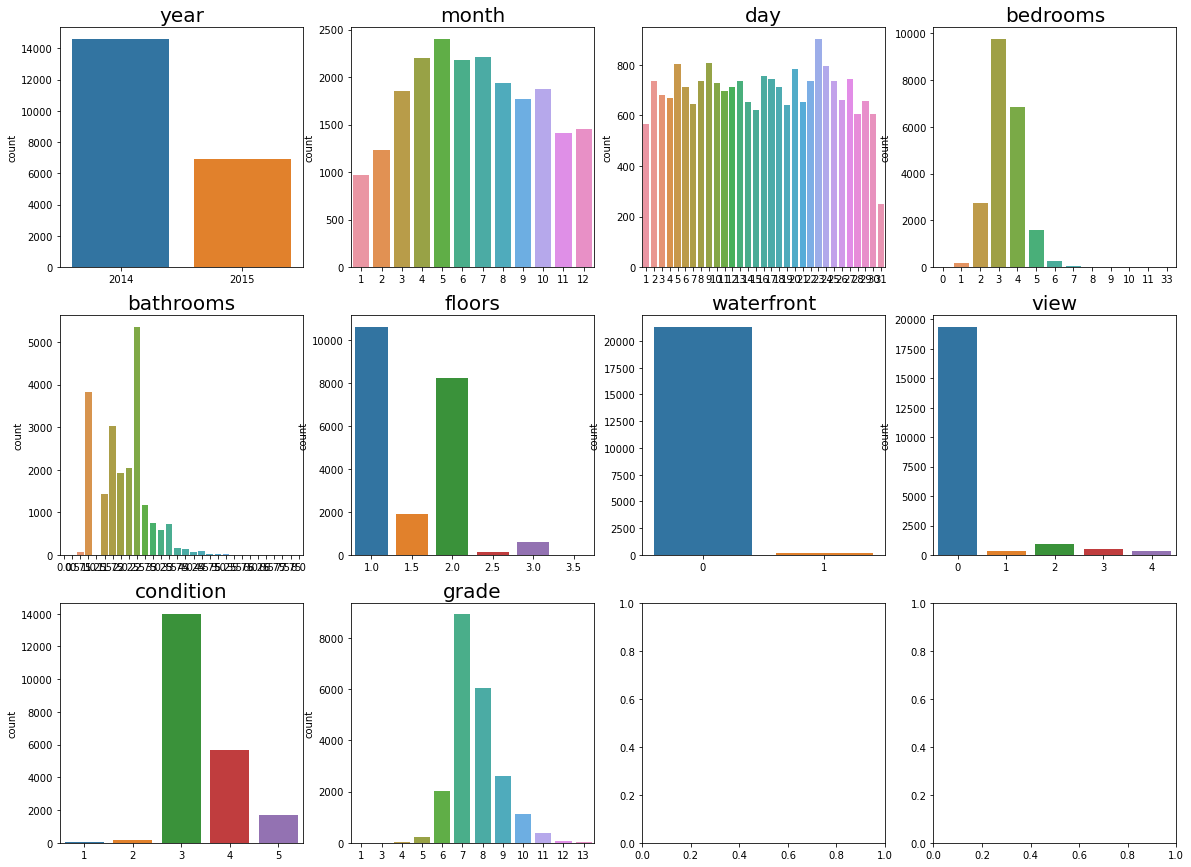

In [50]:
count_info = ['year', 'month', 'day', 'bedrooms', 'bathrooms', 'floors', 'waterfront', 'view', 'condition', 'grade']
fig, axes = plt.subplots(3, 4, figsize=(20, 15))

for r in range(3):
    for c in range(4):
        index = 4 * r + c
        if index == len(count_info):
            break
        sns.countplot(data=data, x=count_info[index], ax=axes[r, c])
        axes[r, c].set_xlabel('')
        axes[r, c].set_title(count_info[index], fontsize=20)

### 2-2. 이산 수치 속성들 간의 상관관계   

데이터는 2014년 5월부터 2015년 5월까지의 집 정보와 가격 정보를 담고 있다.   
grade, view, condition에 비례하여 집 가격이 높아지고 있다.  
waterfront인지 아닌지에 따른 가격 차이가 존재한다.  
floors의 소수점은 다락방 등을 의미하는 것으로 보인다. 


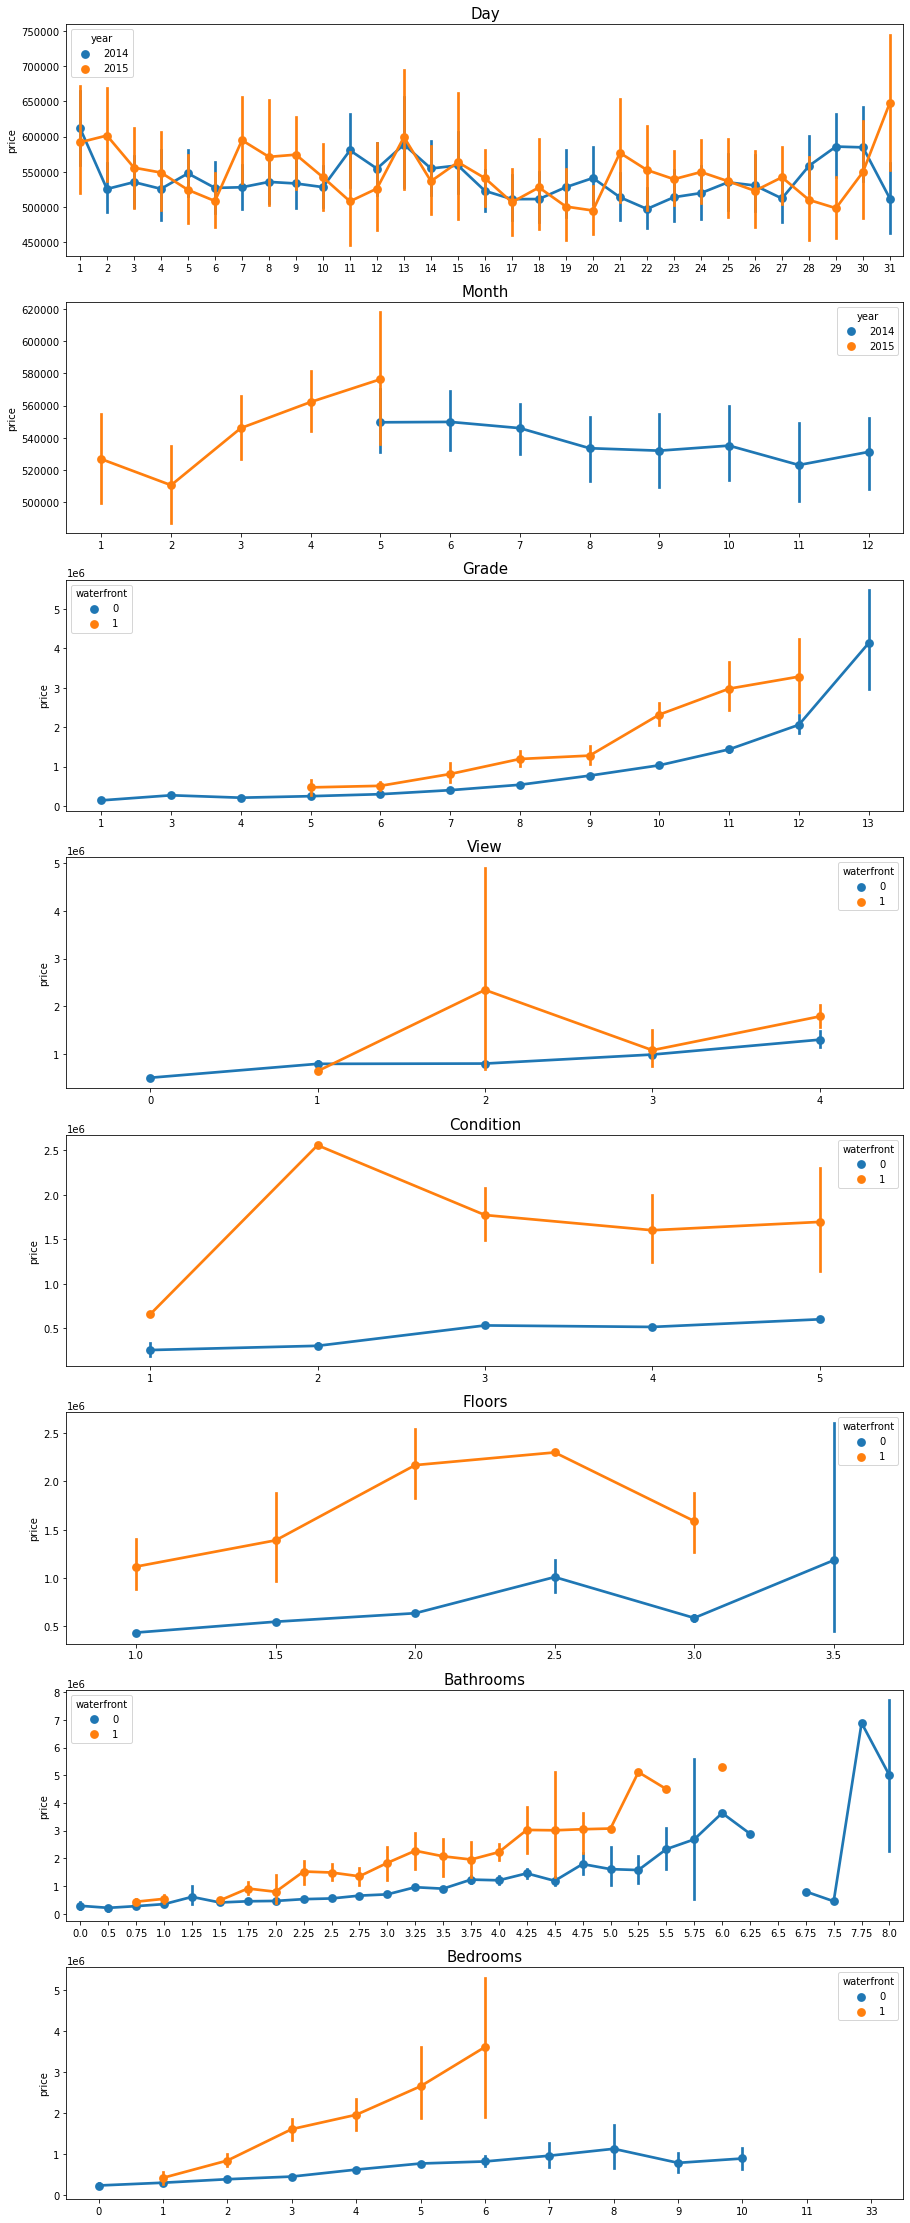

In [51]:
fig, axes = plt.subplots(nrows=8, figsize=(15, 40))

sns.pointplot(data=data, x='day', y='price', hue='year', ax=axes[0])
sns.pointplot(data=data, x='month', y='price', hue='year', ax=axes[1])
sns.pointplot(data=data, x='grade', y='price', hue='waterfront', ax=axes[2])
sns.pointplot(data=data, x='view', y='price', hue='waterfront', ax=axes[3])
sns.pointplot(data=data, x='condition', y='price', hue='waterfront', ax=axes[4])
sns.pointplot(data=data, x='floors', y='price', hue='waterfront', ax=axes[5])
sns.pointplot(data=data, x='bathrooms', y='price', hue='waterfront', ax=axes[6])
sns.pointplot(data=data, x='bedrooms', y='price', hue='waterfront', ax=axes[7])

title = ['Day', 'Month', 'Grade', 'View', 'Condition', 'Floors', 'Bathrooms', 'Bedrooms']
for i in range(8):
    axes[i].set_xlabel('')
    axes[i].set_title(title[i], fontsize=15)
plt.show()

### 2-3. 연속 수치 속성들 간의 상관관계

sqft_living은 실질적으로 살 수있는 공간  

sqft_living > sqft_lot인 집이 많은 것으로 보아, sqft_living은 gross floor area로 계산이 되고 있다.  

만약 어떤 주택의 1층의 면적이 500이고 2층의 면적이 300이라면, sqft_living은 800으로 계산한다.  
  
추가적으로, sqft_living = sqft_above + sqft_basement이며, sqft_basement는 지하실의 면적  
sqft_above = 연면적(미국에선 바닥면적)  
sqft_living을 층 수로 나누어도 여전히 sqft_lot보다 큰 집들이 있다.  

건축 관련 수치들:  
건폐율(building coverage) = 건축면적 / 대지면적  
연면적(floor area ratio) = 연면적(바닥면적) / 대지면적  
sqft_lot과 sqft_lot15은 단일 속성으로서 price와 상관관계가 적은 것으로 보인다.  

In [52]:
corrMatt = train[['price', 'sqft_living', 'sqft_lot', 'sqft_above', 'sqft_basement', 'sqft_living15', 'sqft_lot15']]
corrMatt = corrMatt.corr()

print(corrMatt)

mask = np.array(corrMatt)
mask[np.tril_indices_from(mask)] = False

                  price  sqft_living  sqft_lot  sqft_above  sqft_basement  \
price          1.000000     0.702899  0.096793    0.608577       0.322218   
sqft_living    0.702899     1.000000  0.176500    0.878736       0.434017   
sqft_lot       0.096793     0.176500  1.000000    0.186242       0.017818   
sqft_above     0.608577     0.878736  0.186242    1.000000      -0.048623   
sqft_basement  0.322218     0.434017  0.017818   -0.048623       1.000000   
sqft_living15  0.586419     0.760271  0.147562    0.737795       0.198380   
sqft_lot15     0.086384     0.184176  0.728458    0.194226       0.018813   

               sqft_living15  sqft_lot15  
price               0.586419    0.086384  
sqft_living         0.760271    0.184176  
sqft_lot            0.147562    0.728458  
sqft_above          0.737795    0.194226  
sqft_basement       0.198380    0.018813  
sqft_living15       1.000000    0.183599  
sqft_lot15          0.183599    1.000000  


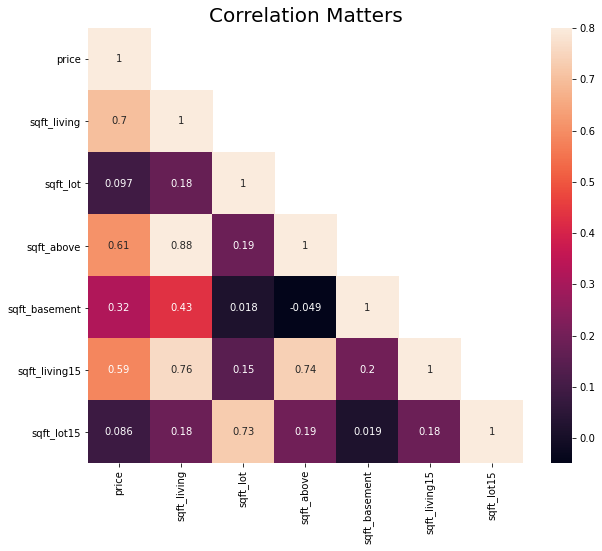

In [53]:
fig, ax = plt.subplots(figsize=(10, 8))

sns.heatmap(corrMatt, mask=mask, vmax=0.8, square=True, annot=True)
ax.set_title('Correlation Matters', fontsize=20)
plt.show()

### 2-4. 가격 분포 확인

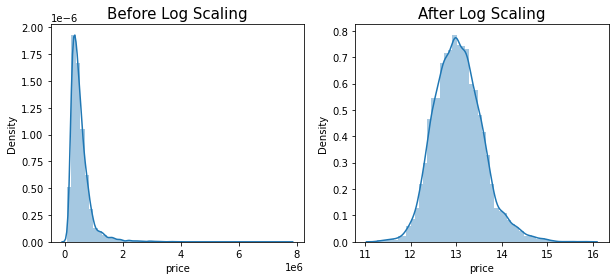

In [54]:
fig, axes = plt.subplots(ncols=2, figsize=(10, 4))

sns.distplot(train['price'], ax=axes[0])
axes[0].set_title('Before Log Scaling', fontsize=15)
sns.distplot(np.log1p(train['price']), ax=axes[1])
axes[1].set_title('After Log Scaling', fontsize=15)
plt.show()

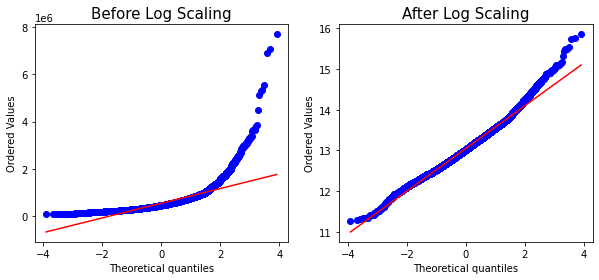

In [55]:
fig, axes = plt.subplots(ncols=2, figsize=(10, 4))

reg = stats.probplot(train['price'], plot=axes[0])
axes[0].set_title('Before Log Scaling', fontsize=15)
reg = stats.probplot(np.log1p(train['price']), plot=axes[1])
axes[1].set_title('After Log Scaling', fontsize=15)
plt.show()

## 3. 전처리

### 3-1. Label Encoding  
zipcode에 Label Encoding  
yr_built = yr_built - 1900 적용  

In [7]:
# 범주형 데이터를 0부터 시작하는 정수형식으로 바꿔준다.
le = LabelEncoder()
le.fit(train['zipcode'])
le.fit(test['zipcode'])

train['zipcode'] = le.transform(train['zipcode'])
test['zipcode'] = le.transform(test['zipcode'])

### 3-2. Feature Engineering  

In [8]:
train['price_per_land_area'] = train['price'] / (train['sqft_living']) #집값 / 주거 공간의 평방 피트 <= 평당가격으로 
price_per_ft = train.groupby(['zipcode'])['price_per_land_area'].agg({'mean', 'std', 'count'}).reset_index()

train = pd.merge(train, price_per_ft, how='left', on='zipcode')
test = pd.merge(test, price_per_ft, how='left', on='zipcode')

del train['price_per_land_area']

In [58]:
train.head() # mean count std 컬럼 추가

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15,mean,count,std
0,0,20141013T000000,221900.0,3,1.00,1180,5650,1.0,0,0,...,1955,0,66,47.5112,-122.257,1340,5650,189.965938,192,75.193536
1,1,20150225T000000,180000.0,2,1.00,770,10000,1.0,0,0,...,1933,0,16,47.7379,-122.233,2720,8062,222.523551,201,51.267030
2,2,20150218T000000,510000.0,3,2.00,1680,8080,1.0,0,0,...,1987,0,37,47.6168,-122.045,1800,7503,267.018622,295,65.381676
3,3,20140627T000000,257500.0,3,2.25,1715,6819,2.0,0,0,...,1995,0,2,47.3097,-122.327,2238,6819,157.972739,185,31.815332
4,4,20150115T000000,291850.0,3,1.50,1060,9711,1.0,0,0,...,1963,0,68,47.4095,-122.315,1650,9711,179.067611,198,65.707370


id, price 변수 처리

In [9]:
X_train = train.drop(['id', 'price'], axis=1)
y_train = train['price']
y_train = np.log1p(y_train)
X_test = test.drop(['id'], axis=1)

In [60]:
train.columns

Index(['id', 'date', 'price', 'bedrooms', 'bathrooms', 'sqft_living',
       'sqft_lot', 'floors', 'waterfront', 'view', 'condition', 'grade',
       'sqft_above', 'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode',
       'lat', 'long', 'sqft_living15', 'sqft_lot15', 'mean', 'count', 'std'],
      dtype='object')

- 연도를 쓰지 않고 2014년 5월부터 2015년 5월까지의 시간을 열 세달(1~13)로 쪼개어 재정렬  → 건축 관련 수치 추가  

- floor_area_ratio(sqft_living / sqft_lot) 추가  →  성능 상승  

- building_coverage(sqft_above / (floor * sqft_lot)) 추가  →  효과 없었음  

- 그 외 여러가지 시도 지하실 유무, 다락방 유무, 재건축 유무 등에 대한 feature를 추가할 수도 있으나 효과 없었음  

- feature의 개수가 많아져서 model complexity가 증가하면 overfitting이 강력해지기 때문으로 추측  

- 방 관련 feature 추가

- 방 총 개수 추가  →  효과 없었음  

- sqft_lot15 제거  →  상황마다 다른 걸로 결론  

- how_old: 건물이 건축되고 리모델링 된 후, 팔리기까지 걸린 시간  

- yr_renovated 제거  


In [10]:
# Adding features
for df in [X_train, X_test]:
    df['date(new)'] = df['date'].apply(lambda x: int(x[4:8])+800 if x[:4] == '2015' else int(x[4:8])-400)
    df['how_old'] = df['date'].apply(lambda x: x[:4]).astype(int) - df[['yr_built', 'yr_renovated']].max(axis=1)
    del df['date']
    del df['yr_renovated']
    df['yr_built'] = df['yr_built'] - 1900
    df['sqft_floor'] = df['sqft_above'] / df['floors']
    df['floor_area_ratio'] = df['sqft_living'] / df['sqft_lot']
    del df['sqft_lot15']

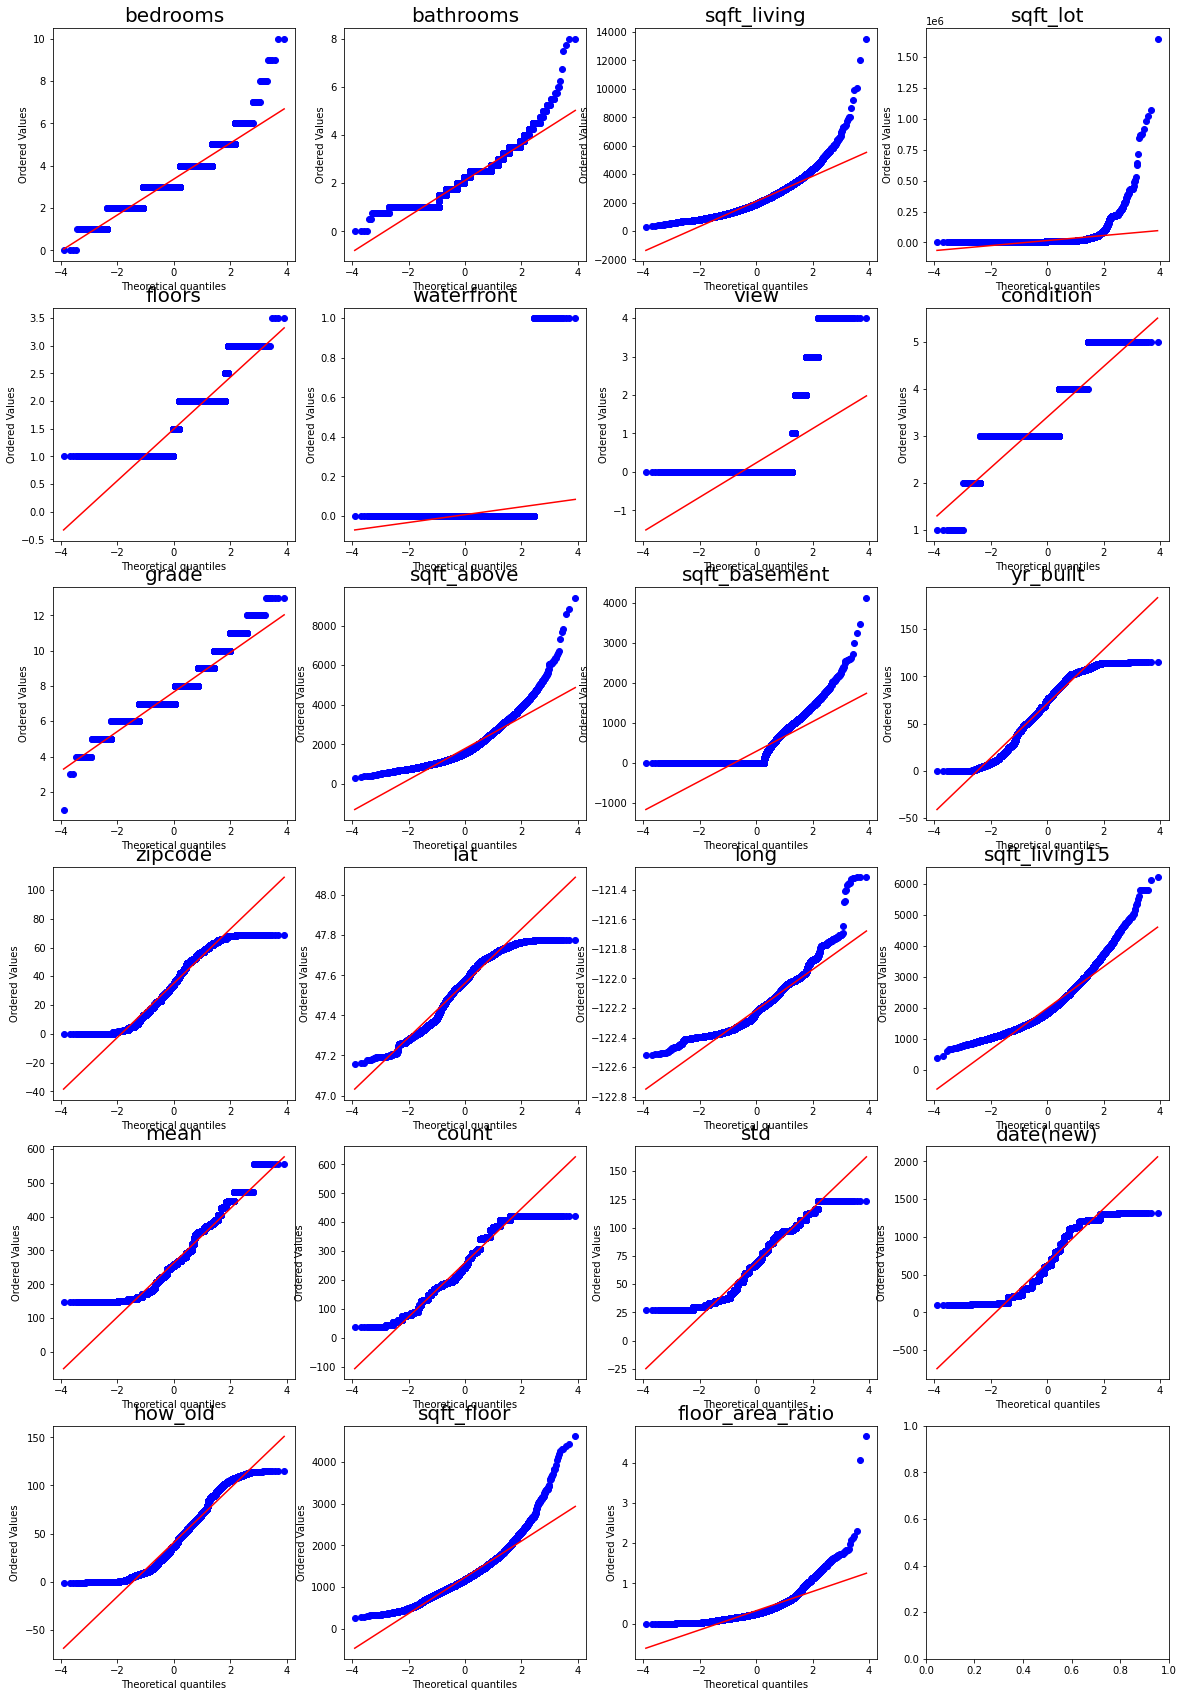

In [62]:
rows = (X_train.shape[1]+3) // 4
fig, axes = plt.subplots(rows, 4, figsize=(20, rows*5))
cols = X_train.columns

for r in range(rows):
    for c in range(4):
        index = 4 * r + c
        if index == len(cols):
            break
        reg = stats.probplot(X_train[cols[index]], plot=axes[r, c])
        axes[r, c].set_title(cols[index], fontsize=20)

### 3-2. Log Scaling  

In [11]:
# Log Scaling
log_features = ['bedrooms', 'bathrooms', 'sqft_lot', 'sqft_living', 'sqft_above', 'sqft_basement', 'sqft_living15', 'sqft_floor', 'mean', 'floor_area_ratio', 'floor_area_ratio']
for feature in log_features:
    for df in [X_train, X_test]:
        df[feature] = np.log1p(df[feature])

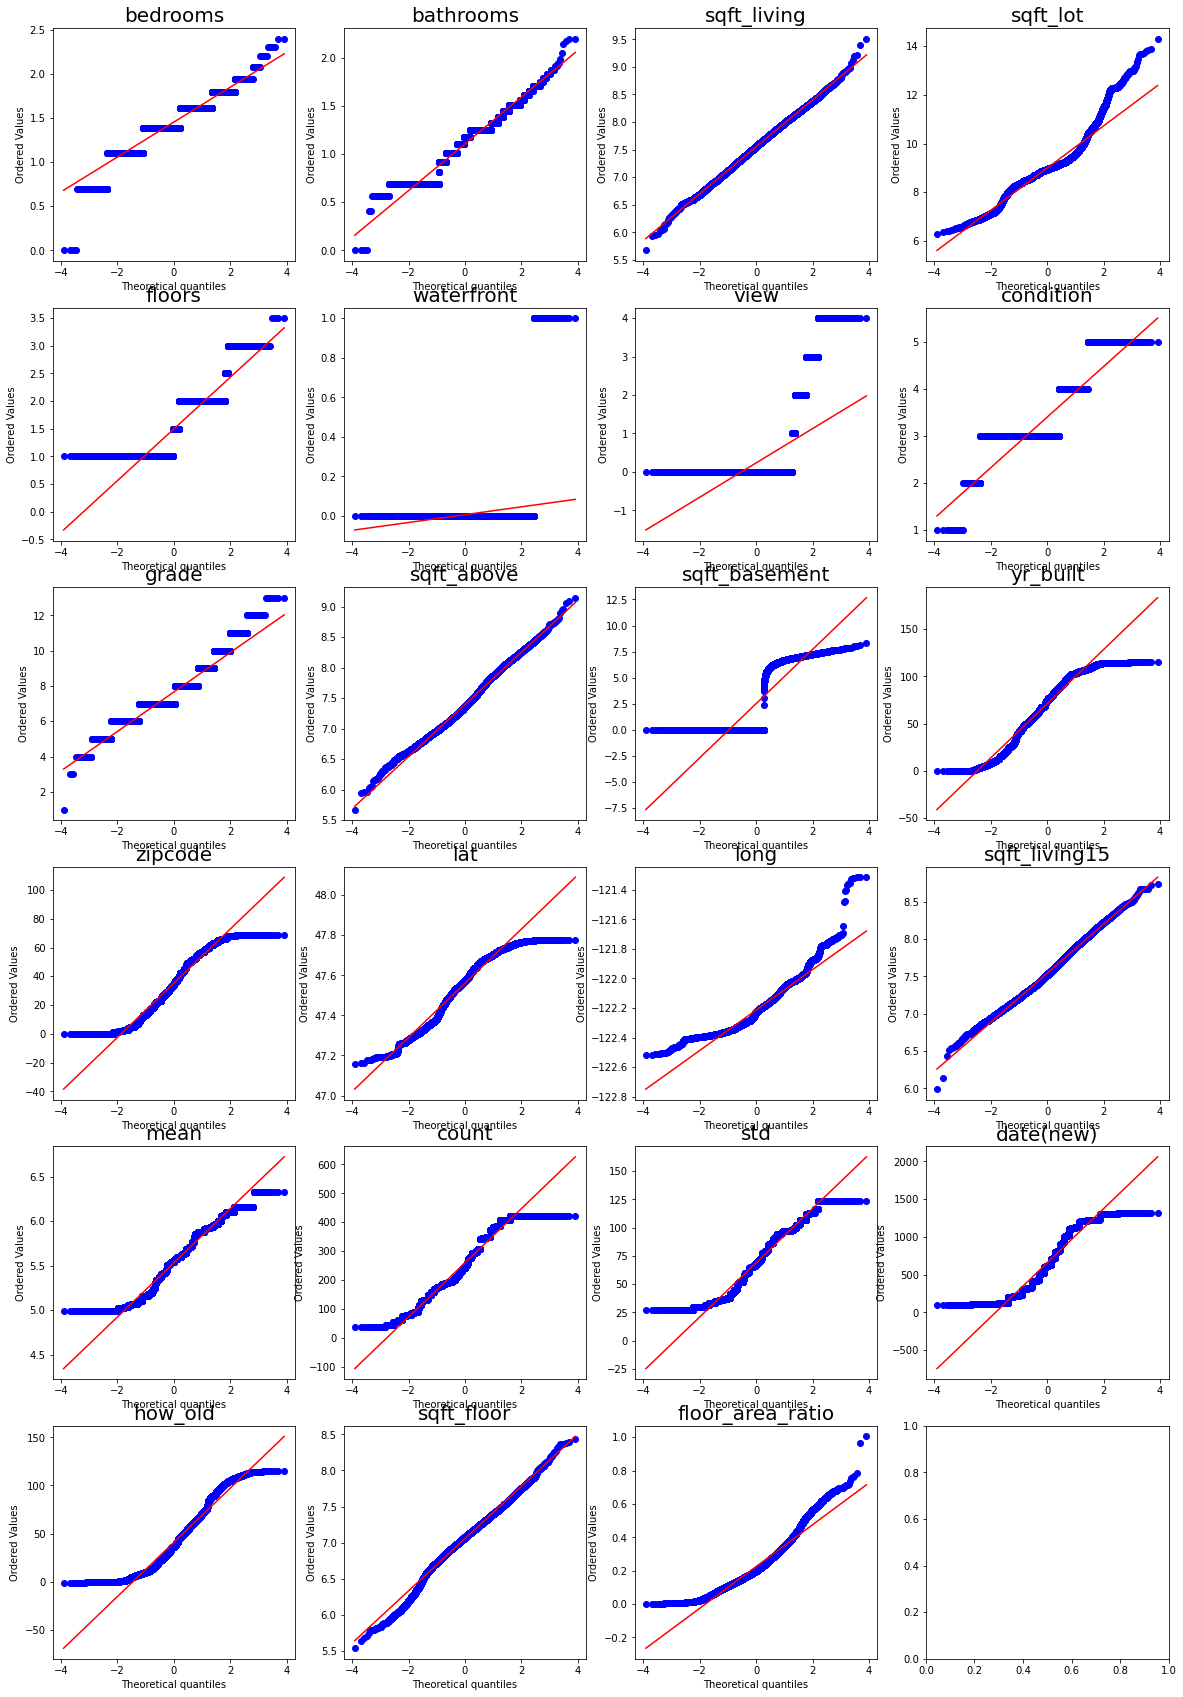

In [64]:
rows = (X_train.shape[1]+3) // 4
fig, axes = plt.subplots(rows, 4, figsize=(20, rows*5))
cols = X_train.columns

for r in range(rows):
    for c in range(4):
        index = 4 * r + c
        if index == len(cols):
            break
        reg = stats.probplot(X_train[cols[index]], plot=axes[r, c])
        axes[r, c].set_title(cols[index], fontsize=20)

## 4. 모델 생성, 학습  
### 4-1. 함수 생성

In [12]:
random_state=2021

그리드 서치 함수

In [13]:
from sklearn.model_selection import GridSearchCV

def my_GridSearch(model, X_train, y_train, param_grid, verbose=2, n_jobs=5):
    #1. GridSearchCV 모델로 `model`을 초기화
    grid_model = GridSearchCV(model, param_grid=param_grid, \
                            scoring='neg_mean_squared_error', \
                            cv=5, verbose=1, n_jobs=5)
    
    #2. 모델을 fitting 
    grid_model.fit(X_train, y_train)
    
    #3. params, score에 각 조합에 대한 결과를 저장 
    params = grid_model.cv_results_['params']
    score = grid_model.cv_results_['mean_test_score']
    
    #4. 데이터 프레임을 생성하고, 
    results = pd.DataFrame(params)
    results['score'] = score
    
    #5. RMSLE 값을 추가한 후 점수가 높은 순서로 정렬한 `results`를 반환
    results['RMSLE'] = np.sqrt(-1 * results['score'])
    results['RMSLE'].sort_values()
    
    return results

submission 저장 함수

In [14]:
def save_submission(model, X_train, y_train, X_test, model_name, rmsle=None):
    
    #1. 모델 훈련
    model.fit(X_train, y_train)
    prediction = model.predict(X_test)
    prediction = np.expm1(prediction)
    
    #2. submission 데이터프레임
    data_dir = os.getenv('HOME')+'/aiffel/kaggle_kakr_housing/data'
    submission_path = join(data_dir, 'sample_submission.csv')
    submission = pd.read_csv(submission_path)
    submission['price'] = prediction
    print(submission.head())

    #3. 결과 저장
    submission_csv_path = '{}/submission_{}_RMSLE_{}.csv'.format(data_dir, model_name, rmsle)
    submission.to_csv(submission_csv_path, index=False)
    print('{} saved!'.format(submission_csv_path))

### 4-2. lightGBM 모델  
**모델 훈련**

In [14]:
param_grid = {
    'n_estimators': [100, 1000],
    'learning_rate' : [0.05, 0.1],
    #'max_depth': [1, 10], 
}

# max_depth : 의사 결정 나무의 깊이, 정수 사용, default -1 제한없이 분기 
# learning_rate : 한 스텝에 이동하는 양을 결정하는 파라미터, 보통 0.0001~0.1 사이의 실수 사용  
# n_estimators : 사용하는 개별 모델의 개수, 보통 50~100 이상의 정수 사용
# num_leaves : 하나의 LightGBM 트리가 가질 수 있는 최대 잎의 수
# boosting_type : 부스팅 방식, gbdt, rf 등의 문자열 입력
    
model = LGBMRegressor(random_state=random_state)
my_GridSearch(model, X_train, y_train, param_grid, verbose=2, n_jobs=5)

Fitting 5 folds for each of 4 candidates, totalling 20 fits


[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done  20 out of  20 | elapsed:    4.3s finished


,learning_rate,n_estimators,score,RMSLE
0,0.05,100,-0.028151,0.167784
1,0.05,1000,-0.025837,0.160739
2,0.10,100,-0.026786,0.163664
3,0.10,1000,-0.026875,0.163936


**가장 좋은 파라미터로 다시 훈련시켜 저장**

In [15]:
#먼저 해당 파라미터로 구성된 모델을 준비하고, 학습 후 예측 결과를 생성
model = LGBMRegressor(learning_rate=0.05, n_estimators=1000, random_state=random_state)

In [18]:
save_submission(model, X_train, y_train, X_test, 'lgbm', rmsle='0.1607')

      id         price
0  15035  5.328611e+05
1  15036  4.953028e+05
2  15037  1.328051e+06
3  15038  3.043320e+05
4  15039  3.221996e+05
/home/ssac6/aiffel/kaggle_kakr_housing/data/submission_lgbm_RMSLE_0.1607.csv saved!


## 5. Late Submission 제출 - Score 109651
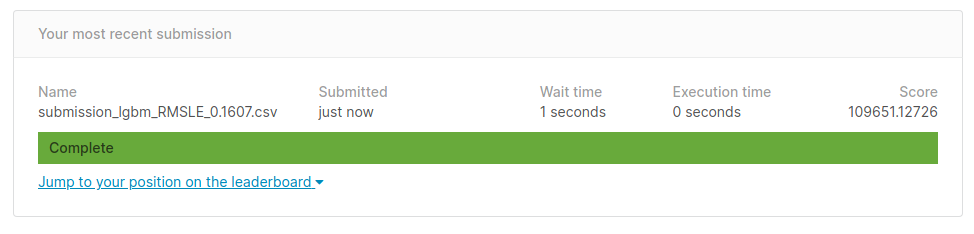

## 느낀점  
kaggle에 참조할 커널이 많았다.   
많은 사람들이 서로를 참조하고, 재생산한 코드들은 점점 진화하고 있었다.   
언젠가는 나도 이들 무리에서 좋은 영향력을 끼치는 사람이 되었으면 하는 생각을 했다.  
피처 엔지니어링을 참조하기 좋은 커널이 있어 EDA와 전처리에 추가하였다.  
모델은 lightGBM을 사용하고, GridSearchCV로 학습을 진행했다.   
제출을 하니 Score 109651 으로 기준선을 겨우 넘었다.   
Kaggel에 참여해 보고 싶었는데, 이번 노드에서 배울 수 있어서 좋았다.   

